## 1. What is the dependent variable you decided?

"Suicides/100k pop" is the most defendable for this assignment. It describes what we are intrested in from this data, is normalized, and is non-imputed. 

HDI would be interesting but it is imputed to the mean, so it's not entirely useful in this case.

In [1]:
# Load libraries and dataset
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from os.path import isfile
from itertools import product

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import OneClassSVM, SVR, SVC


sns.set(style='ticks', color_codes=True)

data_path = './datasets/Suicide_Rates.csv'

suicides = pd.DataFrame()
if not isfile(data_path):
    print("Dataset not found. Please check that the dataset exists and the path is correct.")
    
else:
    suicides = pd.read_csv(data_path)
    
    
# GDP per year is recorded as strings and not ints so fix that real quick
suicides = suicides.rename(columns={' gdp_for_year ($) ': 'gdp_for_year ($)'})

suicides['gdp_for_year ($)'] = suicides['gdp_for_year ($)'].str.replace(',', '')
suicides['gdp_for_year ($)'] = suicides['gdp_for_year ($)'].apply(int)

display(suicides)


,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,2156624900,796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,2156624900,796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,2156624900,796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,2156624900,796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,2156624900,796,Boomers
...,...,...,...,...,...,...,...,...,...,...,...,...
27815,Uzbekistan,2014,female,35-54 years,107,3620833,2.96,Uzbekistan2014,0.675,63067077179,2309,Generation X
27816,Uzbekistan,2014,female,75+ years,9,348465,2.58,Uzbekistan2014,0.675,63067077179,2309,Silent
27817,Uzbekistan,2014,male,5-14 years,60,2762158,2.17,Uzbekistan2014,0.675,63067077179,2309,Generation Z
27818,Uzbekistan,2014,female,5-14 years,44,2631600,1.67,Uzbekistan2014,0.675,63067077179,2309,Generation Z


In [2]:
# Impute
HDI_mean = suicides['HDI for year'].mean() # used in part 6
suicides['HDI for year'] = suicides['HDI for year'].fillna(HDI_mean)

# Adapted from Assignment 3 soln.
# Discretize
def discretize(df):
    df['sex'] = df['sex'].replace({
        'female':0,
        'male':1})
    df['age'] = df['age'].replace({
        '5-14 years':10,
        '15-24 years':20,
        '25-34 years':30,
        '35-54 years':45,
        '55-74 years':65,
        '75+ years':80})
    df['generation'] = df['generation'].replace({
        'G.I. Generation':1,
        'Silent':2,
        'Boomers':3,
        'Generation X':4,
        'Millenials':5,
        'Generation Z':6})
    
    return df

suicides = discretize(suicides)

suicides_org = suicides.copy()

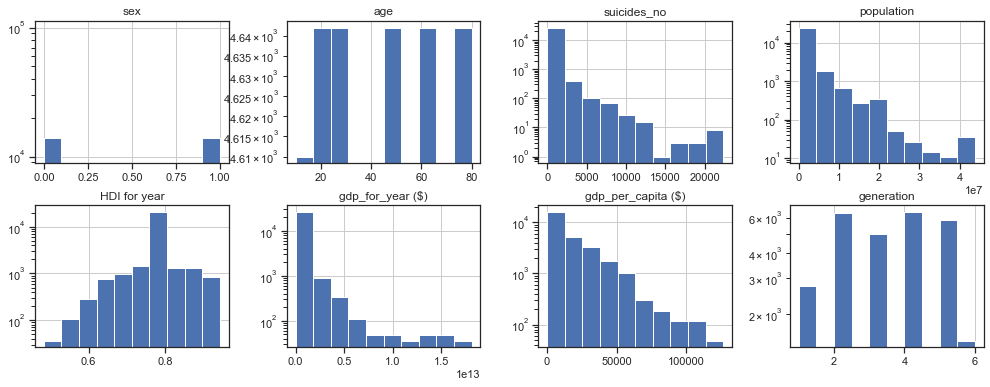

In [3]:
hist = suicides_org.copy()
hist.hist(column=['sex', 'age', 'suicides_no', 'population', 'HDI for year',
                  'gdp_for_year ($)', 'gdp_per_capita ($)', 'generation'],
        log=True,
        figsize=(17, 6), layout=(2,4))

plt.show()

In [4]:
# Remove extra
suicides.drop(columns=['country', 'suicides_no', 'country-year', 'population', 'gdp_for_year ($)', 'gdp_per_capita ($)'], inplace=True)

display(suicides)

,year,sex,age,suicides/100k pop,HDI for year,generation
0,1987,1,20,6.71,0.776601,4
1,1987,1,45,5.19,0.776601,2
2,1987,0,20,4.83,0.776601,4
3,1987,1,80,4.59,0.776601,1
4,1987,1,30,3.28,0.776601,3
...,...,...,...,...,...,...
27815,2014,0,45,2.96,0.675000,4
27816,2014,0,80,2.58,0.675000,2
27817,2014,1,10,2.17,0.675000,6
27818,2014,0,10,1.67,0.675000,6


## 2. Split the dependent variable into two categories.

High and low like in the assignment 3 solution, but I'm going to make different cuts from high to low.

In [5]:
# Get stats
s_100k = suicides['suicides/100k pop'].values
y_mean = np.mean(s_100k)
y_std = np.std(s_100k)

In [6]:
# Get high/low splits @ 1/2 std, 2/3 std, and 3/4 std

labels = ['Low', 'High']

# Half std
target_1_2 = pd.cut(suicides['suicides/100k pop'], bins=[np.NINF, (y_mean + 0.5*y_std), np.Infinity], labels=labels)

# 2/3 std
target_2_3 = pd.cut(suicides['suicides/100k pop'], bins=[np.NINF, (y_mean + 2/3*y_std), np.Infinity], labels=labels)

# 3/4 std
target_3_4 = pd.cut(suicides['suicides/100k pop'], bins=[np.NINF, (y_mean + 3/4*y_std), np.Infinity], labels=labels)

targets = [target_1_2, target_2_3, target_3_4]

In [11]:
# Split/prepare the training sets

X = suicides.loc[:, suicides.columns != 'suicides/100k pop'].values
print(X[0])

Ys = []
for target in targets:
    vals = target.values
    le = LabelEncoder()
    vals = le.fit_transform(vals)
    Ys.append(vals)
    
Ys = {'1/2': Ys[0], '2/3': Ys[1], '3/4': Ys[2]}

[1.98700000e+03 1.00000000e+00 2.00000000e+01 7.76601148e-01
 4.00000000e+00]


## 3./4. Develop and Evaluate models

Based on testing there is a drop off in return on accuracy when we restrict the "High" class to less than a third of the PDF.

*When I set pos_label in f1_score to 0 SVC appears to not predict correctly at all. Not sure why it is behaving that badly on the f1.*

In [8]:
models = [SVC(), RandomForestClassifier(max_depth=10, min_samples_leaf=1, class_weight='balanced')]

# Adapted from module 3 soln.
def evaluate(model, x, y, score=f1_score):
    acc = []
    kf = StratifiedKFold(n_splits=10, shuffle=False, random_state=None)
    for train_index, test_index in kf.split(x, y):
        model.fit(x[train_index], y[train_index])
        y_pred = model.predict(x[test_index])
        acc += [score(y[test_index], y_pred)]
        
    return np.array(acc)

In [9]:
# this cell chuggs. ("Shut'er down Earl, she's a-pumpin' mud.")
for model, y in product(models, Ys):
    acc = evaluate(model, X, Ys[y])
    
    print(f'Model: {model} Target Split: {y} Accuracy: {np.mean(acc):.2f} {chr(177)}{np.std(acc):.3f}')
    

[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
Model: SVC() Target Split: 1/2 Accuracy: 0.90 ±0.000
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
Model: SVC() Target Split: 2/3 Accuracy: 0.92 ±0.000
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
Model: SVC() Target Split: 3/4 Accuracy: 0.93 ±0.000
[1 0 1 ... 0 0 0]
[1 1 1 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 1 1 ... 0 0 1]
[0 1 1 ... 1 0 0]
[1 1 1 ... 0 0 0]
[1 0 1 ... 0 0 0]
[1 1 1 ... 0 0 0]
[1 1 1 ... 1 1 0]
[0 0 0 ... 1 1 1]
Model: RandomForestClassifier(class_weight='balanced', max_depth=10) Target Split: 1/2 Accuracy: 0.84 ±0.015
[1 0 1 ... 0

## 6. Predict with Designated Input

Designated input: year=2000, generation=Generation X, age=20, gender=male

Since I include HDI in my model I'm going to:

a.) predict with the mean for HDI on a RandomForestClassifier

b.) drop HDI and predict on a RandomForestClassifier

In [10]:
designated1 = [2000, 1, 20, HDI_mean, 4]
designated2 = [2000, 1, 20, 4]

ValueError: If using all scalar values, you must pass an index

In [ ]:
pred = 